<img src='../images/header.png' style='height: 50px; float: left'>

## Introduction to Computational Social Science methods with Python

# Session C2: Multilayer and multimodal network construction

In [Session C1: Network construction and visualization](1_network_construction_and_visualization.ipynb), we have encountered the richness of transactional Digital Behavioral Data (DBD). We have used the Pandas package to organize network data from the Copenhagen Networks Study (CNS) as nodelists and edgelists. We have studied methods to construct social networks from social relations, to aggregate these relations over time to obtain edge weights, and to use the attributes stored in nodelists and edgelists in network visualization. Graph theory provides the concepts of undirected, directed, attributed, and weighted graphs for those purposes. Here, we will encounter two additional concepts.

|<img src='../images/copenhagen.jpg' style='float: right; width: 480px'>|
|:--|
|<em style='float: center'>**Figure 1**: Four different types of social relations in the Copenhagen Networks Study interaction data</em>|

First, there can be **multilayer networks** where each layer consists of a different edge type. The idea of layers is fundamental in sociological theory because the roles of persons in social life are thought to originate from the interdependence of multiple domains like family, work, or friendship circles, and domains can be operationalized as network layers. In digital life, layers can also represent transactions in different platforms (*e.g.*, Facebook, YouTube) or from different protocols (*e.g.*, phone calls, text messages). ***Figure 1*** depicts the four layers which are available as the CNS interaction data (Sapiezynski *et al.*, 2019). Multilayer network analysis with this dataset has demonstrated that physical social gatherings measured via physical mobile phone proximity are coordinated by phone calls and text messages hours before the gatherings (Sekara *et al.*, 2016). Layers can also correspond to temporal network snapshots to study the evolution of a social system (Platt, 2019, 142–146; Menczer *et al.*, 2020, pp. 26–28).

Second, there can be **multimodal networks** where nodes belong to distinct categories (the modes), and edges are only permitted among nodes belonging to different categories. For two categories, these networks are called 2-mode networks, **bipartite networks**, or affiliation networks (Platt, 2019, ch. 4; Ma & Seth, 2020, 89–101). The classical example is the network of persons having participated in (being affiliated with) events. The corresponding analyses shed light on the duality or micro-macro relationship of persons and groups (Breiger, 1974). Due to its transactional and rich nature, DBD often has more than two modes. Such data allows for studies of socio-cultural networks but requires non-trivial mathematical data preprocessing (Lee & Martin, 2018). Figure 3 in [Session A2: Data management with Pandas](../a_introduction/2_data_management_with_pandas.ipynb) shows the seven tables used to organize the TweetsCOV19 dataset. Since entities are only linked to entities of other categories, this dataset, in principle, allows for constructing 7-mode networks, though, in practice, one would reduce the number of modes to keep interpretability.

<div class='alert alert-block alert-success'>
<b>In this session</b>, 

you will learn to work with multilayer and multimodal networks and how those enable you to think relationally. We will continue using the NetworkX package. Subsession **C2.1** is dedicated to multilayer networks, creating a communication network with text message and phone call layers. In subsession **C2.2**, we approach the dynamic nature of networks and see how different kinds of snapshots can be constructed from temporal aggregation and combined in a multilayer graph. Subsession **C2.3** is about bipartite networks and about how nodes of one mode can be projected into edges among nodes of the other mode. Finally, in subsession **C2.4**, we will see how we remove the layer information from graphs.
</div>

## Learning objectives

By the end of this session, you should be able to
- understand the full richness of network data,
- construct multilayer networks with multiple types of edges,
- process dynamic network data by aggregating edges into network snapshots,
- construct bipartite networks and project them to networks of only one node type,
- remove information from information-rich networks,
- export networks for later analysis (in other sessions).

## C2.1. Multilayer networks

|<img src='../images/mux_models.png' style='float: none; width: 480px'>|
|:--|
|<em style='float: center'>**Figure 2**: Spectrum of multilayer networks (Copyright 2013-2033, Manlio De Domenico, [source](https://doi.org/10.17605/OSF.IO/GY53K))</em>|

Artime *et al.* (2022, p. 9) conceptualize the four kinds of multilayer networks shown in ***Figure 2***. In the non-interconnected model or **edge-colored multigraphs**, there is no interlayer connectivity other than that nodes can have edges in multiple layers (with multiple colors). NetworkX realized this by creating parallel edges and assigning those a key which defines the layer. Here, we only work with the non-interconnected multilayer model. The other, interconnected models invole well-defined interlayer connectivity and allow for modeling interdependencies where, for example, nodes control or are controlled by nodes in other networks. Such analyses are quite advanced and require data structures that are not implemented in NetworkX. The [Pymnet](http://www.mkivela.com/pymnet/) package which builds on top of NetworkX is a first step towards more user-friendly multilayer analysis.

#### Communication: Text messages and phone calls

In this subsection, the goal is to construct a communication network where text messages and phone calls resemble different layers. We will load the edgelists of both social relations, filter them, combine them into one edgelist, and create an edge-colored multigraph. We have constructed the directed weighted short message graph aggregated over the first week in the previous session. This is the short version:

In [1]:
import numpy as np
import pandas as pd

In [2]:
def aggregate_edges(df, time, source, target, weight, time_zero, window_size, inclusive, fun):
    '''
    Aggregates edges from a time-stamped edge list according to an aggregation function.
    
    Parameters:
        df : Pandas DataFrame
            Time-stamped edgelist.
        time : String
            Name of the column in df which contains the timestamp.
        source : String
            Name of the column in df which contains the source node.
        target : String
            Name of the column in df which contains the target node.>
        weight : String or None
            Name of the column in df which contains the edge weights. If None, a column with unit edge weights will be created.
        time_zero : String or numerical
            Time where aggregation begins.
        window_size : String or numerical
            Size of the time window used for aggregation.
        inclusive : {'both', 'neither', 'left', 'right'}
            Include boundaries. Whether to set each bound as closed or open.
        fun : {'max', 'sum', 'mean'}
            Aggregation method. Either the maximum edge weight is used, weights are summer, or weights are averaged.
    
    Returns:
        Aggregated edge list consisting of a node pair and a weight column.
    '''
    if weight == None:
        weight = 'weight'
        df[weight] = 1
    if fun == 'max':
        df_agg = df[df[time].between(left=time_zero, right=time_zero+window_size, inclusive=inclusive)].groupby([source, target]).max().reset_index()[[source, target, weight]]
    if fun == 'sum':
        df_agg = df[df[time].between(left=time_zero, right=time_zero+window_size, inclusive=inclusive)].groupby([source, target]).sum().reset_index()[[source, target, weight]]
    if fun == 'mean':
        df_agg = df[df[time].between(left=time_zero, right=time_zero+window_size, inclusive=inclusive)].groupby([source, target]).mean().reset_index()[[source, target, weight]]
    return df_agg

In [3]:
edgelist_cns_sms = pd.read_csv('../data/CNS/sms.csv')
edgelist_cns_sms_week1 = aggregate_edges(df=edgelist_cns_sms, time='timestamp', source='sender', target='recipient', weight=None, time_zero=0, window_size=604800, inclusive='left', fun='sum')
edgelist_cns_sms_week1['weight'] = np.log(edgelist_cns_sms_week1['weight']) + 1

Now, we proceed with the second network. Load the phone call edgelist:

In [4]:
edgelist_cns_calls = pd.read_csv('../data/CNS/calls.csv')
edgelist_cns_calls.head()

,timestamp,caller,callee,duration
0,184,300,301,121
1,3920,512,299,670
2,5623,301,300,504
3,9252,401,457,-1
4,15466,512,0,5


In [5]:
with open('../data/CNS/calls.README', 'r') as f:
    print(f.read())

column names:
	- timestamp
	- calling user
	- call recipient
	- duration (-1 means a missed call)




Phone call relations are directed and weighted by the `duration` of a call. Remove missed calls and calls with zero duration:

In [6]:
edgelist_cns_calls = edgelist_cns_calls[edgelist_cns_calls['duration'] > 0]

Aggregate the edges over the first week (`window_size = 604800` seconds), this time taking the mean call duration:

In [7]:
edgelist_cns_calls_week1 = aggregate_edges(
    df = edgelist_cns_calls, 
    time = 'timestamp', 
    source = 'caller', 
    target = 'callee', 
    weight = 'duration', 
    time_zero = 0, 
    window_size = 604800, 
    inclusive = 'left', 
    fun = 'mean'
)
edgelist_cns_calls_week1.head()

,caller,callee,duration
0,0,512,3.0
1,4,424,16.0
2,6,27,2.0
3,6,406,52.0
4,8,557,17.5


In [8]:
edgelist_cns_calls_week1['duration'].max()

1440.0

In [9]:
edgelist_cns_calls_week1['duration'].skew()

5.215480916459532

Again the edge weight distribution is quite skewed. The largest average call duration is 24 minutes (1440 seconds). To obtain a well-behaved weight distribution for the short message graph, we took the natural logarith of the number of short messages sent in a week. Now we take the logarithm with base 10 of the average call duration:

In [10]:
edgelist_cns_calls_week1['duration'] = np.log10(edgelist_cns_calls_week1['duration']) + 1

Taking the logarithm with different bases for messages and calls results in comparable means after transformation. This is desired when creating a multilayer network:

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

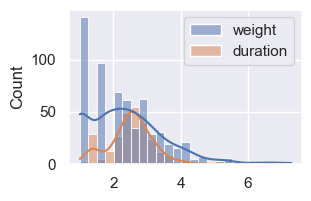

In [12]:
plt.figure(figsize=[3, 2])
sns.histplot(
    data=(edgelist_cns_sms_week1['weight'], edgelist_cns_calls_week1['duration']), 
    kde=True
)
plt.show()

Before combining both edgelists into one, we harmonize their column names:

In [13]:
edgelist_cns_sms_week1.columns = ['source', 'target', 'weight']
edgelist_cns_calls_week1.columns = ['source', 'target', 'weight']

Finally, we add layer attributes:

In [14]:
edgelist_cns_sms_week1['layer'] = 0
edgelist_cns_calls_week1['layer'] = 1

Now that the two edgelists are ready, we concatenate them into one communication edgelist:

In [15]:
edgelist_cns_communication_week1 = pd.concat([edgelist_cns_sms_week1, edgelist_cns_calls_week1]).reset_index(drop=True)
edgelist_cns_communication_week1

,source,target,weight,layer
0,0,512,4.526361,0
1,1,345,1.693147,0
2,3,49,2.791759,0
3,3,357,4.135494,0
4,4,221,1.693147,0
...,...,...,...,...
873,805,459,2.322219,1
874,812,179,2.000000,1
875,812,656,2.380211,1
876,845,228,2.462398,1


In the list we have just created, the edges have two attributes: 'weight' and 'layer'. We will now use them to construct a **multilayer graph** $G_{LW}=(V,E,L,W)$ where $V$ is a set of vertices, $E$ is a set of edges, $L=\{l_1, l_2, ..., l_p\}$ is a set of layers attached to the edges, and $W$ is a set of weights attached to the layers. Use the 'weight' and 'layer' attributes in the `from_pandas_edgelist()` function, now creating a `MultiDiGraph` (directed multilayer network):

In [16]:
# If you are running this session in Google Colab, install this package version
#!pip install networkx==2.8.4

In [17]:
import networkx as nx
nx.__version__

'2.8.4'

In [18]:
MD_cns_communication_week1 = nx.from_pandas_edgelist(
    df = edgelist_cns_communication_week1, 
    source = 'source', 
    target = 'target', 
    edge_attr = 'weight', 
    create_using = nx.MultiDiGraph, 
    edge_key = 'layer'
)

We also want to add the 'sex' attribute to the nodes in the graph. The following steps are explained in depth in the previous session:

In [19]:
def get_attr_values(df, type_of_list, attr, node='name', source='source', target='target'):
    '''
    Transforms one or multiple columns of a nodelist or edgelist into a dictionary that can be used to set the node or 
    edge attributes of a graph.
    
    Parameters:
        df : Pandas DataFrame
            Nodelist or edgelist that contains the node or edge attributes.
        type_of_list : String, either 'nodes' or 'edges'
            To specify if attribute values should be created for nodes or edges.
        attr : List
            List containing the names of the columns in df that contain the attribute values.
        name : String, only required if df is a 'nodes' type_of_list, default 'name'
            Column name of the nodelist containing the node labels.
        source : String, only required if df is an 'edges' type_of_list, default 'source'
            Column name of the edgelist containing the source node labels.
        target : String, only required if df is an 'edges' type_of_list, default 'target'
            Column name of the edgelist containing the target node labels.
    
    Returns:
        Dictionary with nodes or edges as keys and an attribute dictionary as values.
    '''
    df_ = df.copy()
    df_ = pd.DataFrame([df_[attr].to_dict('records')]).T
    if type_of_list == 'nodes':
        df_.index = df[node]
    if type_of_list == 'edges':
        df_.index = list(zip(df[source], df[target]))
    return list(df_.to_dict().values())[0]

In [20]:
nodelist_cns = pd.read_csv('../data/CNS/nodelist.csv')
MD_cns_communication_week1.add_nodes_from(nodelist_cns['user'])
node_attr_sex = get_attr_values(df=nodelist_cns, type_of_list='nodes', attr=['sex'], node='user')
nx.set_node_attributes(G=MD_cns_communication_week1, values=node_attr_sex)

Each layer is defined by a key, and the keys can be viewed by:

In [21]:
#MD_cns_communication_week1.edges.keys()

Again we extract the largest weakly connected component...

In [22]:
MD_cns_communication_week1_lcc = MD_cns_communication_week1.subgraph(nodes=sorted(nx.weakly_connected_components(MD_cns_communication_week1), key=len, reverse=True)[0])

and create and internalize a layout:

In [23]:
pos_cns_communication_week1 = nx.kamada_kawai_layout(
    G = MD_cns_communication_week1_lcc, 
    weight = None
)
nx.set_node_attributes(G=MD_cns_communication_week1_lcc, values=pos_cns_communication_week1, name='pos')

The network is now ready for visualization. A list of layer keys is created and used for the `edge_color` parameter (line 20). Using colored nodes in addition to the colored edges may be too much information to process visually. Hence, we decide to encode the 'sex' attribute as node shapes. For that purpose, we must use the `draw_networkx_nodes()` function. First we loop through the three categories (male, female, and unknown) (lines 4–14), create a `nodelist` for each (line 8), and give all nodes from the same category the same shape (line 11). Then we draw the edges using the `draw_networkx_edges()` function where we can now use a transparency parameter `alpha` that only applies to the edges (lines 15–24):

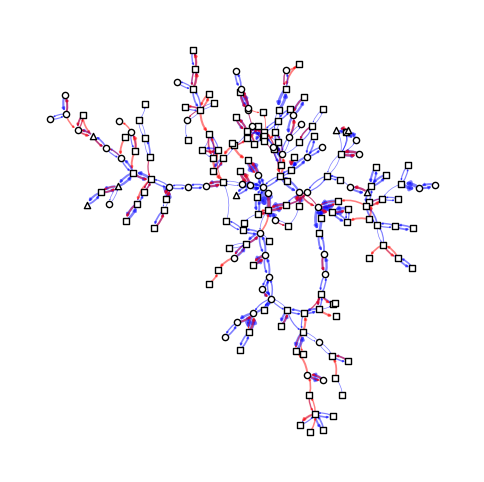

In [24]:
shapes = ['s', 'o', '^']

plt.figure(figsize=[6, 6])
for i in range(3):
    nx.draw_networkx_nodes(
        G = MD_cns_communication_week1_lcc, 
        pos = nx.get_node_attributes(G=MD_cns_communication_week1_lcc, name='pos'), 
        nodelist = [node for node, attribute in MD_cns_communication_week1_lcc.nodes(data=True) if attribute['sex'] == i], 
        node_size = 20, 
        node_color = 'white', 
        node_shape = shapes[i], 
        linewidths = 1., 
        edgecolors = 'black'
    )
nx.draw_networkx_edges(
    G = MD_cns_communication_week1_lcc, 
    pos = nx.get_node_attributes(G=MD_cns_communication_week1_lcc, name='pos'), 
    width = [width/2 for width in nx.get_edge_attributes(G=MD_cns_communication_week1_lcc, name='weight').values()], 
    edge_color = [key for u, v, key in MD_cns_communication_week1_lcc.edges.keys()], 
    alpha = .5, 
    edge_cmap = plt.cm.bwr, 
    arrowsize = [arrowsize for arrowsize in nx.get_edge_attributes(G=MD_cns_communication_week1_lcc, name='weight').values()], 
    connectionstyle = 'arc3, rad=0.2', 
    node_size = 20
)
plt.box(False)
plt.savefig('results/MD_cns_communication_week1_lcc.pdf')
plt.savefig('results/MD_cns_communication_week1_lcc.png')

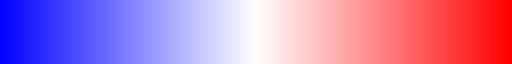

In [25]:
plt.cm.bwr

In this network plot, the `bwr` colormap is used to color the layers. This colormap diverges from blue to red. Matplotlib maps the key 0 (short messages) to blue and 1 (phone calls) to red. The result is an edge-colored multigraph.

## C2.2. Network snapshots from link streams

The text message and phone call edgelists are examples of **link streams** where edges are time-stamped, and edges among pairs of nodes can appear, be repeated, or terminated. Such continuous longitudinal data is well suited to study human behavior (*e.g.*, institutionalization, mechanisms of structural stability and change). The researcher is confronted with the problem how to handle these timestamps. Relational event modeling allows for modeling actions within social settings in a continuous way (Butts *et al.*, 2023). These models require advanced statistical knowledge and, at this point, programming skills outside Python. For example, the [relevent](https://cran.r-project.org/web/packages/relevent/index.html) package uses an R interface.

Most analyses use link streams in a discrete way, which means, the data is aggregated into a series of **network snapshots**, like the `..._communication_week1` network constructed above. The first way to aggregate link streams is to use constant time windows for aggregation. These typically rely on dates (*e.g.*, days, weeks, months) and times (*e.g.*, hours, minutes, seconds). Choosing this window is user-defined and can be quite arbitrary – why aggregate over three hours, not four? Therefore, a second way is to aggregate until a structural criterion is met (Soundarajan *et al.*, 2016). Such methods can – and typically do – result in variable time windows. Below, we will aggregate edges by clock and by network connectivity.

#### Physical proximity

The physical proximity relations of the CNS dataset resemble a link stream at high temporal resolution. Physical proximity of two students is measured using the Bluetooth devices of the cell phones handed out to the students. These devices scan their environment every five minutes and record the presence of other phones. All instances of students A and B discovering each other were identified, and the larger signal strength (`rssi`) is reported (Sapiezynski et al., 2019).

In [26]:
edgelist_cns_bt = pd.read_csv('../data/CNS/bt_symmetric.csv.gz')
edgelist_cns_bt.head()

,# timestamp,user_a,user_b,rssi
0,0,0,-1,0
1,0,1,-1,0
2,0,2,-1,0
3,0,3,-2,-88
4,0,5,-1,0


In [27]:
with open('../data/CNS/bt_symmetric.README', 'r') as f:
    print(f.read())

column names:
	- timestamp
	- user A 
	- user B 
	- received signal strength

Notes:
Empty scans are marked with user B = -1 and RSSI = 0
Scans of devices outside of the experiment are marked with user B = -2. All non-experiment devices are given the same ID.



Remove relations involving devices not participating in the experiment as well as four nonsensical relations with positive signal strengths:

In [28]:
edgelist_cns_bt = edgelist_cns_bt[(edgelist_cns_bt['user_b'] >= 0) & (edgelist_cns_bt['rssi'] < 0)].reset_index(drop=True)

RSSI is a value between -100 and 0. As a rule of thumb, an RSSI signal strength of -75 means that two devices are 1 meter apart (Mones *et al.*, 2017). Values closer to 0 mean devices are also closer. Hence, according to the histogram and the filtering in the following two cells, about 18% of all relations are within a face-to-face interaction distance of 1 meter:

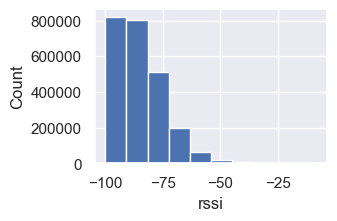

In [29]:
plt.figure(figsize=[3, 2])
edgelist_cns_bt['rssi'].hist()
plt.xlabel('rssi')
plt.ylabel('Count')
plt.show()

In [30]:
len(edgelist_cns_bt[edgelist_cns_bt['rssi'] >= -75]) / len(edgelist_cns_bt)

0.18074744206654234

Since positive values can be interpreted more easily, add a new 'strength' column that shifts the RSSI score into the positive range:

In [31]:
edgelist_cns_bt['strength'] = edgelist_cns_bt['rssi'] + 100

### C2.2.1 Aggregating edges by clock

Sekara *et al.* (2016) have shown that social groups can be uncovered in the network of physical proximity by tuning the time window for aggregation. When they plotted the network of who was proximate to whom during a whole day, it did not reveal anything interesting. The network of social relations aggregated over one hour, however, exhibited a large connected component with visible groups. When aggregating edges over one scanning period (5 minutes), groups were isolated (Sekara *et al.* 2016, fig. 1).

We use the same time windows: 5 minutes, 1 hour, and 1 day correspond to 300, 3600, and 86400 seconds, respectively. Use a subplot for each window defined in `window_sizes` and labeled in `window_labels`:

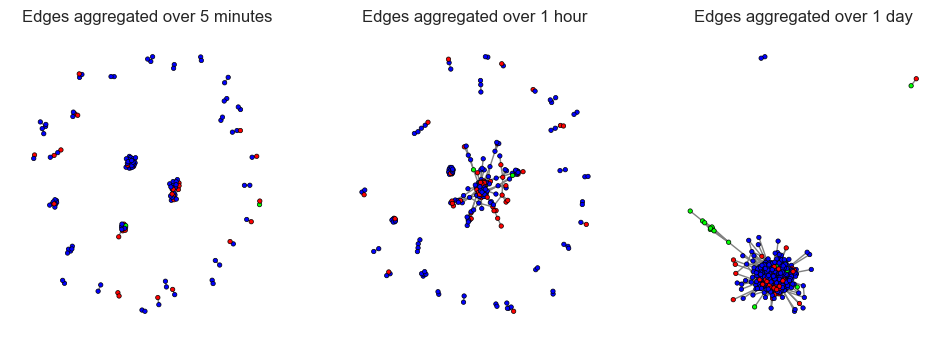

In [32]:
time_zero = 118800
window_sizes = [300, 3600, 86400]
window_labels = ['5 minutes', '1 hour', '1 day']

fig, axs = plt.subplots(1, len(window_sizes), figsize=(12, 4))
for i in range(len(window_sizes)):
    df_agg = aggregate_edges(
        df = edgelist_cns_bt, 
        time = '# timestamp', 
        source = 'user_a', 
        target = 'user_b', 
        weight = 'strength', 
        time_zero = time_zero, 
        window_size = window_sizes[i], 
        inclusive = 'left', 
        fun = 'sum'
    )
    G_agg = nx.from_pandas_edgelist(
        df = df_agg, 
        source = 'user_a', 
        target = 'user_b', 
        edge_attr = ['strength'], 
        create_using = nx.Graph
    )
    nx.set_node_attributes(G=G_agg, values=node_attr_sex)
    axs[i].set_title('Edges aggregated over '+window_labels[i])
    nx.draw(
        G = G_agg, 
        ax = axs[i], 
        node_size = 10, 
        node_color = list(nx.get_node_attributes(G=G_agg, name='sex').values()), 
        cmap = plt.cm.brg, 
        linewidths = .5, 
        edgecolors = 'black', 
        edge_color = 'gray'
    )

As in the paper by Sekara *et al.*, we uncover different network structures at varying windows sizes. The graph on the left is a subgraph of the graph in the middle which is a subgraph of the graph on the right.

Interested in 28 networks of 1 day each, displayed in `i` = 4 rows and `j` = 7 columns? Initialize a subplot array with shape (4, 7) and loop through each dimension. Again, we are using our custom `aggregate_edges()` function. Note that we increase `time_zero` by the `window_size` in the last line to create the day snapshots:

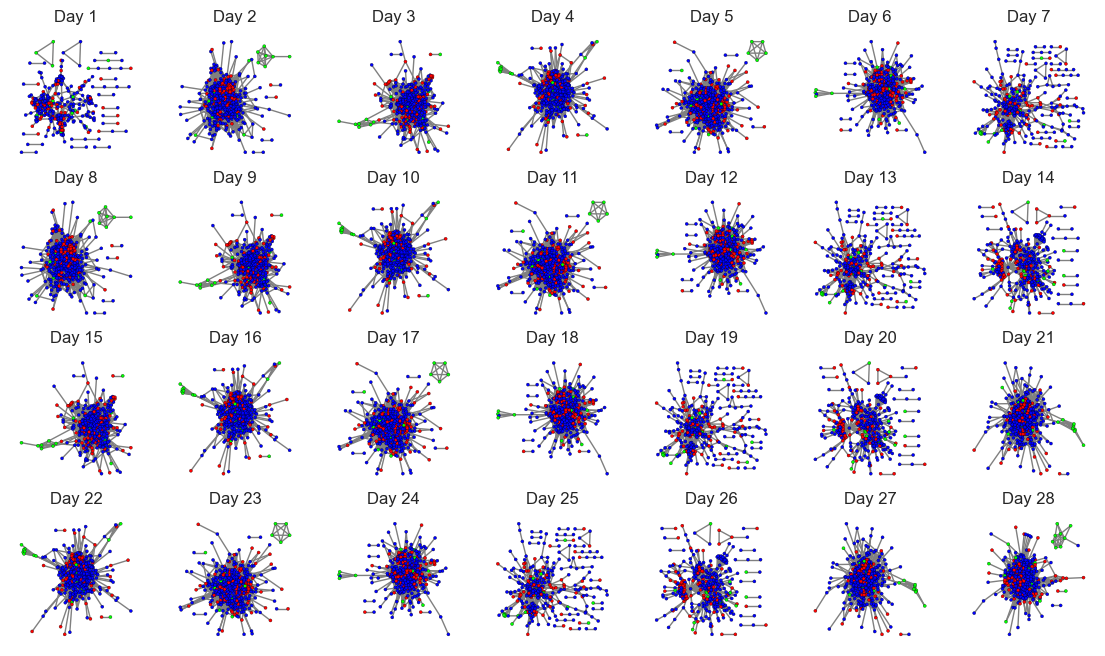

In [33]:
time_zero = 0
window_size = 86400
edgelists_cns_bt_day = []

fig, axs = plt.subplots(4, 7, figsize=(14, 8))
for i in range(4):
    for j in range(7):
        edgelists_cns_bt_day.append(aggregate_edges(
            df = edgelist_cns_bt, 
            time = '# timestamp', 
            source = 'user_a', 
            target = 'user_b', 
            weight = 'strength', 
            time_zero = time_zero, 
            window_size = window_size, 
            inclusive = 'left', 
            fun = 'sum'
        ))
        G_agg = nx.from_pandas_edgelist(
            df = edgelists_cns_bt_day[i+j], 
            source = 'user_a', 
            target = 'user_b', 
            edge_attr = ['strength'], 
            create_using = nx.Graph
        )
        nx.set_node_attributes(G=G_agg, values=node_attr_sex)
        axs[i, j].set_title('Day '+str(i*7+j+1))
        nx.draw(
            G = G_agg, 
            pos = nx.nx_agraph.graphviz_layout(G=G_agg, prog='sfdp'), 
            ax = axs[i, j], 
            node_size = 5, 
            node_color = list(nx.get_node_attributes(G=G_agg, name='sex').values()), 
            cmap = plt.cm.brg, 
            linewidths = .2, 
            edgecolors = 'black', 
            edge_color = 'gray'
        )
        time_zero += window_size

Note the "green" cluster of five or more students that repeatedly forms an isolated component. These are students that did not report their sex in the survey or did not participate in the survey at all. Obviously, the decision to not report the sex was made in the group, or the group formed because the students were like-minded.

The edgelists for all 28 days are stored in the `edgelists_cns_bt_day` list of dataframes. You can use these edgelists, for example, to create a multilayer network. Access the first edgelist like this:

In [34]:
#edgelists_cns_bt_day[0]

### C2.2.2. Aggregating edges by network connectivity

Many networks of the 28 daily snapshots look like hairballs. Reducing the aggregation window size will reveal a more patterned structure. But what window size to use? For some snapshots 6 hours may be best, for others 12. Here, we use a simple method that stops aggregation when at least a certain fraction `p_criterion` of the students are connected in the largest component. It is an application of the framework proposed by Soundarajan *et al.* (2016).

Imagine that we want to study how students behave (who interacts with whom) on day 2 between 09:00 and 17:00. And let us say that we are interested in face-to-face interactions where students are within 1m of each other. First filter the edgelist to obtain very-close-range proximity:

In [35]:
edgelist_cns_bt_f2f = edgelist_cns_bt[edgelist_cns_bt['rssi'] >= -75]

Now define integer variables for `time_begin` and `time_end`, set `p_criterion = .5` (you can change it to experiment!), and prepare some empty lists in which results will be stored (lines 5–8). Then enter a loop where edges are aggregated `while time_begin < time_end` (line 10). In this aggregation loop, the empirical fraction `p` of nodes in the largest component is computed (line 32) as the `window_size` is increased (line 33). Aggregation continues `while p < p_criterion` (line 13). Edge weights are summed in aggregation (line 23). When `p` is larger or equal `p_criterion`, aggregation of the next snapshot will start (line 42). Aggregation will also stop when the end of the analysis period has been reached (`time_begin + window_size > time_end` in line 34–36):

In [36]:
time_begin = (24 + 9) * 60 * 60
time_end = (24 + 17) * 60 * 60
p_criterion = .5

time_windows = []
edgelists_cns_bt_f2f_p = []
Gs_cns_bt_f2f_p = []
counter = 1

while time_begin < time_end:
    p = 0.
    window_size = 300
    while p < p_criterion:
        df_agg = aggregate_edges(
            df = edgelist_cns_bt_f2f, 
            time = '# timestamp', 
            source = 'user_a', 
            target = 'user_b', 
            weight = 'strength', 
            time_zero = time_begin, 
            window_size = window_size, 
            inclusive = 'left', 
            fun='sum'
        )
        G_agg = nx.from_pandas_edgelist(
            df = df_agg, 
            source = 'user_a', 
            target = 'user_b', 
            edge_attr = ['strength'], 
            create_using = nx.Graph
        )
        p = G_agg.subgraph(sorted(nx.connected_components(G_agg), key=len, reverse=True)[0]).number_of_nodes() / G_agg.number_of_nodes()
        window_size += 300
        if time_begin + window_size > time_end:
            print('Snapshot ' + str(counter) + ' is not complete, p =', round(p, 2))
            break
    print('Snapshot ' + str(counter) + ' is from ' + str(time_begin) + ' to ' + str(time_begin + window_size - 300))
    time_windows.append(window_size - 300)
    counter += 1
    edgelists_cns_bt_f2f_p.append(df_agg)
    Gs_cns_bt_f2f_p.append(G_agg)
    time_begin += window_size

Snapshot 1 is from 118800 to 125400
Snapshot 2 is from 125700 to 129600
Snapshot 3 is from 129900 to 132600
Snapshot 4 is from 132900 to 141900
Snapshot 5 is not complete, p = 0.25
Snapshot 5 is from 142200 to 147600


There are this many snapshots, the last of which is not complete:

In [37]:
len(edgelists_cns_bt_f2f_p)

5

For the stated value of `p_criterion`, the distribution of snapshot window sizes is:

In [38]:
pd.DataFrame(data=time_windows, columns=['time_window']).groupby('time_window').size()

time_window
2700    1
3900    1
5400    1
6600    1
9000    1
dtype: int64

Temporal networks can be represented as multilayer networks (Platt, 2019, 142–146; Menczer *et al.* 2020, pp. 26–28). Next, we want to construct and draw a multilayer network where layers are temporal snapshots. Create an empty dataframe `edgelist_cns_bt_f2f_p` and add snapshot edgelist by snapshot edgelist:

In [39]:
edgelist_cns_bt_f2f_p = pd.DataFrame(columns = ['user_a', 'user_b', 'strength', 'snapshot'])
for snapshot in range(len(edgelists_cns_bt_f2f_p) - 1):
    df = edgelists_cns_bt_f2f_p[snapshot].copy()
    df['snapshot'] = snapshot
    edgelist_cns_bt_f2f_p = pd.concat([edgelist_cns_bt_f2f_p, df])
edgelist_cns_bt_f2f_p = edgelist_cns_bt_f2f_p.sort_values(by='strength', ascending=True).reset_index(drop=True)

Construct the undirected MultiGraph with the 'sex' node attributes:

In [40]:
MG_cns_bt_f2f_p = nx.from_pandas_edgelist(
    df = edgelist_cns_bt_f2f_p, 
    source = 'user_a', 
    target = 'user_b', 
    edge_attr = ['strength'], 
    create_using = nx.MultiGraph, 
    edge_key = 'snapshot'
)
#MG_cns_bt_f2f_p.add_nodes_from(nodelist_cns['user'])
nx.set_node_attributes(G=MG_cns_bt_f2f_p, values=node_attr_sex)

Extract the largest connected component...

In [41]:
MG_cns_bt_f2f_p_lcc = MG_cns_bt_f2f_p.subgraph(sorted(nx.connected_components(MG_cns_bt_f2f_p), key=len, reverse=True)[0])

and plot it, again using node shapes for the attribute and layer keys as the edge color:

In [42]:
pos_cns_bt_f2f_p_lcc = nx.kamada_kawai_layout(
    G = MG_cns_bt_f2f_p_lcc, 
    weight = None
)
nx.set_node_attributes(G=MG_cns_bt_f2f_p_lcc, values=pos_cns_bt_f2f_p_lcc, name='pos')

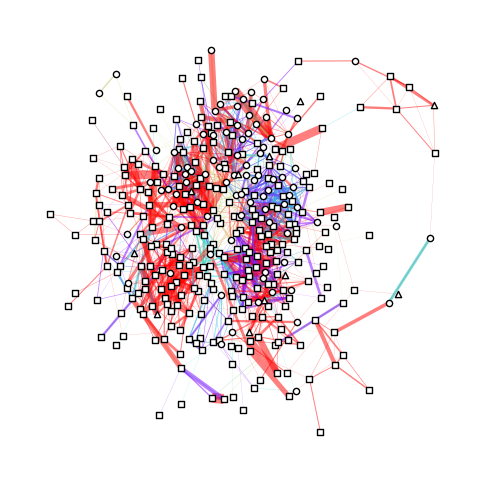

In [43]:
plt.figure(figsize=[6, 6])
for i in range(3):
    nx.draw_networkx_nodes(
        G = MG_cns_bt_f2f_p_lcc, 
        pos = nx.get_node_attributes(G=MG_cns_bt_f2f_p_lcc, name='pos'), 
        nodelist = [node for node, attribute in MG_cns_bt_f2f_p_lcc.nodes(data=True) if attribute['sex'] == i], 
        node_size = 20, 
        node_color = 'white', 
        node_shape = shapes[i], 
        linewidths = 1., 
        edgecolors = 'black'
    )
nx.draw_networkx_edges(
    G = MG_cns_bt_f2f_p_lcc, 
    pos = nx.get_node_attributes(G=MG_cns_bt_f2f_p_lcc, name='pos'), 
    width = [width/200 for width in nx.get_edge_attributes(G=MG_cns_bt_f2f_p_lcc, name='strength').values()], 
    edge_color = [key for u, v, key in MG_cns_bt_f2f_p_lcc.edges.keys()], 
    alpha = .5, 
    edge_cmap = plt.cm.rainbow, 
    node_size = 20
)
plt.box(False)
plt.savefig('results/MG_cns_bt_f2f_p_lcc.pdf')
plt.savefig('results/MG_cns_bt_f2f_p_lcc.png')

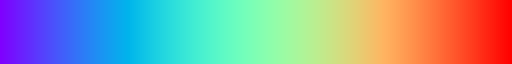

In [44]:
plt.cm.rainbow

This plot is structurally interesting as it seems to exhibit groups of nodes that are separated by structural gaps. Using the `rainbow` colormap to color edges means that purple will be used for the first snapshot (from 09:00 to 10:55), red for the fourth snapshot (from 12:55 to 15:30), and intermediate colors for the two snapshots in between. The fact that different colors dominate different regions of the graph means that the associated groups meet at different times.

What these examples of aggregating networks by clock and by network connectivity tell you is that network construction can very well be an analytical step.

## C2.3. Bipartite networks

The richness of Digital Behavioral Data can take the form of multimodality, where units of analysis belong to different categories (have different modes). Here, we introduce how to handle bipartite or 2-mode network data (Platt, 2019, ch. 4; Ma & Seth, 2020, pp. 89–101). A **bipartite graph** $B=(U, V, E)$ consists of two disjoint and independent sets of vertices $U$ and $V$ and an edge set $E$. Disjoint means that $U$ and $V$ have no vertex in common, and independent means that vertices of a set are not allowed to be connected to vertices of the same set. Hence, edges are only permitted between vertices belonging to different sets. Examples of bipartite networks may be persons participating in events, hashtags being used in tweets, or products being bought by customers.

|<img src='images/bipartite_graph.svg' style='float: none; width: 240px'>|
|:--|
|<em style='float: center'>**Figure 3**: Bipartite network (Wikimedia Commons. [Source](https://commons.wikimedia.org/wiki/File:Simple_bipartite_graph;_two_layers.svg))</em>|

The network in ***Figure 3*** may depict five persons (in red) having participated in one to three of four events (in blue). By using matrix multiplication, this network can be [projected](https://en.wikipedia.org/wiki/Bipartite_network_projection) into two unipartite or 1-mode networks: a network of persons that are connected if they participated in the same events and a network of events that are connected if the same persons participated in them. We will now discuss how bipartite network data can be organized and how you can project the nodes of one mode into edges among nodes of the other mode. The CNS does not include bipartite data. We use a classical dataset:

#### Southern women data

[Southern women](https://networkdata.ics.uci.edu/netdata/html/davis.html) is a dataset of 18 women observed in the 1930s as they met in a series of 14 social events over a period of nine months. The matrix by Davis *et al.* reports which women met for which events. The dataset is small, so it can be stored as a dense matrix (where dense means that zeros are also saved and use memory):

In [45]:
matrix_davis = pd.DataFrame(data=[[0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0], [0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0], [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0], [0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0], [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0], [0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1], [0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1], [0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0], [0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0], [0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0], [0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0], [1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0], [1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1]], index=['Eleanor', 'Brenda', 'Dorothy', 'Verne', 'Flora', 'Olivia', 'Laura', 'Evelyn', 'Pearl', 'Ruth', 'Sylvia', 'Katherine', 'Myrna', 'Theresa', 'Charlotte', 'Frances', 'Helen', 'Nora'], columns=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
matrix_davis

,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Eleanor,0,1,0,1,0,0,0,1,0,0,0,1,0,0
Brenda,0,1,0,1,0,0,1,1,0,1,0,1,1,0
Dorothy,0,0,0,0,0,1,0,0,0,0,0,1,0,0
Verne,0,0,0,1,1,1,0,0,0,0,0,1,0,0
Flora,1,0,0,0,0,1,0,0,0,0,0,0,0,0
Olivia,1,0,0,0,0,1,0,0,0,0,0,0,0,0
Laura,0,1,1,1,0,0,1,1,0,1,0,1,0,0
Evelyn,0,1,1,0,0,1,1,1,0,1,0,1,1,0
Pearl,0,0,0,0,0,1,0,1,0,0,0,1,0,0
Ruth,0,1,0,1,0,1,0,0,0,0,0,1,0,0


This is how Breiger (1974) presents the bipartite matrix. Consult his paper for a sociological analysis of this data and the network transformations discussed in the following. A tidy way of managing bipartite data is to use **two nodelists**: one for the $U$ and $V$ sets each. There are no node attributes, so the nodelists will only contain the node labels:

In [46]:
nodelist_davis_women = pd.DataFrame(data=matrix_davis.index, columns=['woman'])
nodelist_davis_events = pd.DataFrame(data=matrix_davis.columns, columns=['event'])

Next we create the edgelist. This can be done by [`stack`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.stack.html)ing all rows of `matrix_davis` on top of each other (line 1) and removing edges with zeros (line 2). The weights resemble the cells of the matrix, so they are all 1:

In [47]:
edgelist_davis = matrix_davis.stack().reset_index()
edgelist_davis = edgelist_davis[edgelist_davis[0] > 0].reset_index(drop=True)
edgelist_davis.columns = ['woman', 'event', 'weight']
edgelist_davis.head()

,woman,event,weight
0,Eleanor,2,1
1,Eleanor,4,1
2,Eleanor,8,1
3,Eleanor,12,1
4,Brenda,2,1


We can still create the network `from_pandas_edgelist()`, but adding the nodes now requires two lines (7 and 8). In this case, the lines will not have an effect because all nodes have edges and are, hence, already in the graph:

In [48]:
G_davis = nx.from_pandas_edgelist(
    df = edgelist_davis, 
    source = 'woman', 
    target = 'event', 
    create_using = nx.Graph
)
G_davis.add_nodes_from(nodelist_davis_women['woman'])
G_davis.add_nodes_from(nodelist_davis_events['event'])

Check if the result really is bipartite:

In [49]:
nx.is_bipartite(G_davis)

True

While we have created the network from two nodelists, NetworkX does not have a graph type dedicated to bipartite networks. Instead, two sets of nodes are used, one set for each mode. The node labels come from the two nodelists. For later use, we will store them in a list:

In [50]:
nodes_davis = [nodelist_davis_women['woman'].tolist(), nodelist_davis_events['event'].tolist()]
print('Mode 0:', nodes_davis[0])
print('Mode 1:', nodes_davis[1])

Mode 0: ['Eleanor', 'Brenda', 'Dorothy', 'Verne', 'Flora', 'Olivia', 'Laura', 'Evelyn', 'Pearl', 'Ruth', 'Sylvia', 'Katherine', 'Myrna', 'Theresa', 'Charlotte', 'Frances', 'Helen', 'Nora']
Mode 1: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


If the bipartite network is connected in one component, the two modes can also be identified from the data:

In [51]:
#nodes_davis = nx.bipartite.sets(G_davis)
#print('Mode 0:', nodes_davis[0])
#print('Mode 1:', nodes_davis[1])

For women, we also want to obtain the number of events they participated in, and for events, the number of women that participated in them. The desired scores are the row sums (`axis=1`) and column sums (`axis=0`) of the bipartite matrix, respectively. Store these values in the nodelists:

In [52]:
nodelist_davis_women['events'] = matrix_davis.sum(axis=1).tolist()
nodelist_davis_events['women'] = matrix_davis.sum(axis=0).tolist()

Storing information in the nodelists is a way to keep your data tidy and grow it systematically. Also store the values in a list to use them in network drawing:

In [53]:
sizes_davis = [nodelist_davis_women['events'].tolist(), nodelist_davis_events['women'].tolist()]
print('Mode 0:', sizes_davis[0])
print('Mode 1:', sizes_davis[1])

Mode 0: [4, 7, 2, 4, 2, 2, 7, 8, 3, 4, 7, 6, 4, 8, 4, 4, 5, 8]
Mode 1: [4, 8, 3, 10, 6, 12, 6, 8, 5, 3, 3, 14, 4, 3]


To draw the node labels using `nx.draw_networkx_labels()` and have control over the font color, we must create a (trivial) list of dictionaries of text labels keyed by node:

In [54]:
labels_davis = []
[labels_davis.append({node: node for node in nodes}) for nodes in nodes_davis]
print('Mode 0:', labels_davis[0])
print('Mode 1:', labels_davis[1])

Mode 0: {'Eleanor': 'Eleanor', 'Brenda': 'Brenda', 'Dorothy': 'Dorothy', 'Verne': 'Verne', 'Flora': 'Flora', 'Olivia': 'Olivia', 'Laura': 'Laura', 'Evelyn': 'Evelyn', 'Pearl': 'Pearl', 'Ruth': 'Ruth', 'Sylvia': 'Sylvia', 'Katherine': 'Katherine', 'Myrna': 'Myrna', 'Theresa': 'Theresa', 'Charlotte': 'Charlotte', 'Frances': 'Frances', 'Helen': 'Helen', 'Nora': 'Nora'}
Mode 1: {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14}


Finally, a layout and some custom colors:

In [55]:
pos_davis = nx.spring_layout(G=G_davis)
node_colors_davis = ['red', 'blue']
font_colors_davis = ['black', 'white']

Since we have systematically stored node attributes in the `nodes_davis`, `sizes_davis`, `node_colors_davis`, `shapes`, `labels_davis`, and `font_colors_davis` lists, we can simply loop through the two modes (line 2). Use list comprehension (line 7) to increase node sizes according to your taste:

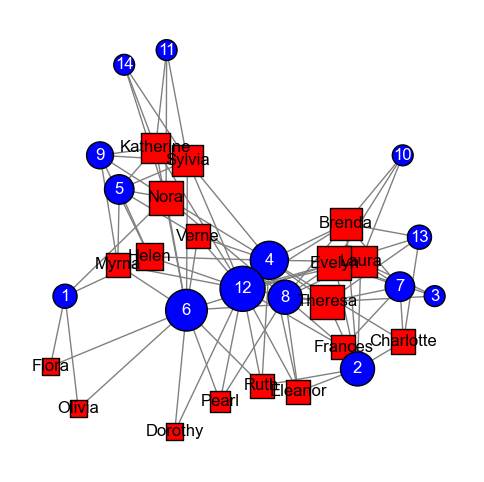

In [56]:
plt.figure(figsize=[6, 6])
for i in range(2):
    nx.draw_networkx_nodes(
        G = G_davis, 
        pos = pos_davis, 
        nodelist = nodes_davis[i], 
        node_size = [75*size for size in sizes_davis[i]], 
        node_color = node_colors_davis[i], 
        node_shape = shapes[i], 
        alpha = 1., 
        linewidths = 1., 
        edgecolors = 'black'
    )
    nx.draw_networkx_labels(
        G = G_davis, 
        pos = pos_davis, 
        labels = labels_davis[i], 
        font_color = font_colors_davis[i]
    )
nx.draw_networkx_edges(
    G = G_davis, 
    pos = pos_davis, 
    edge_color = 'gray'
)
plt.box(False)

#### Network projections

Matrix multiplication is the mathematical operation behind the projection of a bipartite matrix. Section A3.2. of [Session A3: Scientific computing and data visualization](../a_introduction/3_scientific_computing_and_data_visualization.ipynb) has introduced the SciPy package to do matrix multiplication. Here, we use NetworkX's [`weighted_projected_graph()`](https://networkx.org/documentation/networkx-2.8.4/reference/algorithms/generated/networkx.algorithms.bipartite.projection.weighted_projected_graph.html?highlight=weighted_projected_graph) function. In terms of graph theory, the projection of a bipartite graph $B$ to mode 0 is the matrix $B_0=B\cdot B^\mathrm{T}$ and to mode 1 $B_1=B^\mathrm{T}\cdot B$ where $B^\mathrm{T}$ is the transpse of $B$. The transpose of a matrix is the matrix with flipped rows and columns. To project `G_davis` to the women mode:

In [57]:
G_davis_women = nx.bipartite.weighted_projected_graph(
    B = G_davis, 
    nodes = nodes_davis[0]
)

The cells in the projected network of women give the number of events they have co-participated in. The result is the matrix in figure 2b by Breiger (1974):

In [58]:
nx.to_pandas_adjacency(G_davis_women).astype('int')

,Eleanor,Brenda,Dorothy,Verne,Flora,Olivia,Laura,Evelyn,Pearl,Ruth,Sylvia,Katherine,Myrna,Theresa,Charlotte,Frances,Helen,Nora
Eleanor,0,4,1,2,0,0,4,3,2,3,2,1,1,4,2,3,2,2
Brenda,4,0,1,2,0,0,6,6,2,3,2,1,1,6,4,4,2,2
Dorothy,1,1,0,2,1,1,1,2,2,2,2,2,2,2,0,1,1,1
Verne,2,2,2,0,1,1,2,2,2,3,4,3,3,3,1,1,3,3
Flora,0,0,1,1,0,2,0,1,1,1,1,1,1,1,0,0,1,2
Olivia,0,0,1,1,2,0,0,1,1,1,1,1,1,1,0,0,1,2
Laura,4,6,1,2,0,0,0,6,2,3,2,1,1,6,3,4,2,2
Evelyn,3,6,2,2,1,1,6,0,3,3,2,2,2,7,3,4,1,2
Pearl,2,2,2,2,1,1,2,3,0,2,2,2,2,3,0,2,1,2
Ruth,3,3,2,3,1,1,3,3,2,0,3,2,2,4,2,2,2,2


To project `G_davis` to the event mode:

In [59]:
G_davis_events = nx.bipartite.weighted_projected_graph(
    B = G_davis, 
    nodes = nodes_davis[1]
)

The cells in the projected network of events give the number of women that have co-participated in them. The result is the matrix in figure 2c by Breiger (1974):

In [60]:
nx.to_pandas_adjacency(G_davis_events).astype('int')

,1,2,3,4,5,6,7,8,9,10,11,12,13,14
1,0,0,0,2,2,3,0,1,2,0,1,1,0,1
2,0,0,3,6,0,3,6,6,0,3,0,7,4,0
3,0,3,0,2,0,2,3,3,0,2,0,3,2,0
4,2,6,2,0,4,5,4,5,3,2,2,8,3,2
5,2,0,0,4,0,5,0,1,5,0,3,5,0,3
6,3,3,2,5,5,0,2,4,4,1,3,9,2,3
7,0,6,3,4,0,2,0,5,0,3,0,5,4,0
8,1,6,3,5,1,4,5,0,1,3,1,7,3,1
9,2,0,0,3,5,4,0,1,0,0,3,4,0,3
10,0,3,2,2,0,1,3,3,0,0,0,3,2,0


To draw the two projections, we use the [`interact()`](https://ipywidgets.readthedocs.io/en/7.6.5/examples/Using%20Interact.html?highlight=interact#Using-Interact) function of the [ipywidgets](https://ipywidgets.readthedocs.io/) package. Our `filter_edges()` function allows you to interactively filter edges by their weight:

In [61]:
import ipywidgets

In [62]:
def filter_edges(G, pos, node_size, node_color, node_shape, font_color, slider_value, slider_min, slider_max, slider_step, weight='weight'):
    '''
    Draws a network with a slider that allows to filter edges by their weight.
    
    Parameters:
        G : NetworkX Graph, DiGraph, MultiGraph, or MultiDiGraph object
            Network that is to be filtered.
        pos : NumPy array
            Node positions.
        node_size : List
            Node sizes.
        node_color : String or (rgba) tuple of floats from 0-1
            Node color.
        node_shape : String
            Node shape.
        font_color : String or (rgba) tuple of floats from 0-1
            Font color.
        slider_value : integer or float
            Initial filter value.
        slider_min : integer or float
            Minimum filter value.
        slider_max : integer or float
            Maximum filter value.
        slider_step : integer or float
            Size of steps with which filter value is slided.
        weight : String, default 'weight'
            Name of edge attribute.
    '''
    def draw_filtered_graph(weight_min):
        G_filter = nx.Graph()
        G_filter.add_nodes_from(nodes_for_adding=G.nodes)
        G_filter.add_edges_from(ebunch_to_add=[(u, v, edge_attr) for u, v, edge_attr in G.edges(data=True) if edge_attr[weight] >= weight_min])
        plt.figure(figsize=[6, 6])
        nx.draw_networkx_nodes(
            G = G_filter, 
            pos = pos, 
            node_size = node_size, 
            node_color = node_color, 
            node_shape = node_shape, 
            linewidths = 1., 
            edgecolors = 'black'
        )
        nx.draw_networkx_labels(
            G = G_filter, 
            pos = pos, 
            font_color = font_color
        )
        nx.draw_networkx_edges(
            G = G_filter, 
            pos = pos, 
            width = list(nx.get_edge_attributes(G_filter, weight).values()), 
            edge_color = 'gray'
        )
        plt.box(False)
    
    ipywidgets.interact(
        draw_filtered_graph, 
        weight_min = ipywidgets.IntSlider(value=slider_value, min=slider_min, max=slider_max, step=slider_step)
    )

In [63]:
filter_edges(
    G = G_davis_women, 
    pos = pos_davis, 
    node_size = [75*size for size in sizes_davis[0]], 
    node_color = node_colors_davis[0], 
    node_shape = shapes[0], 
    font_color = font_colors_davis[0], 
    slider_value = 1, 
    slider_min = 1, 
    slider_max = 7, 
    slider_step = 1
)

interactive(children=(IntSlider(value=1, description='weight_min', max=7, min=1), Output()), _dom_classes=('wi…

Removing all event edges weaker than 4 (`weight_min = 4`) uncovers the two social groups of women discussed in the literature (Breiger, 1974). These groups consist of women that participated in many events (the nodes are large) and in the same events many times. Women in the same group can be assumed to know each other better than women in the other group.

In [64]:
filter_edges(
    G = G_davis_events, 
    pos = pos_davis, 
    node_size = [75*size for size in sizes_davis[1]], 
    node_color = node_colors_davis[1], 
    node_shape = shapes[1], 
    font_color = font_colors_davis[1], 
    slider_value = 1, 
    slider_min = 1, 
    slider_max = 7, 
    slider_step = 1
)

interactive(children=(IntSlider(value=1, description='weight_min', max=7, min=1), Output()), _dom_classes=('wi…

Increasingly removing edges in the event network uncovers that the large events 2, 4, 6, 8, and 12 were crucial in bringing the women of both groups together.

<div class='alert alert-block alert-warning'>
<b>Additional resources</b>

The [`weighted_projected_graph()`](https://networkx.org/documentation/networkx-2.8.4/reference/algorithms/generated/networkx.algorithms.bipartite.projection.weighted_projected_graph.html?highlight=weighted_projected_graph) function to project a bipartite graph creates weighted edges for the projected graphs but does not take edge weights of the bipartite network into accont. If this is what you want to do, use the [`generic_weighted_projected_graph()`](https://networkx.org/documentation/networkx-2.8.4/reference/algorithms/generated/networkx.algorithms.bipartite.projection.generic_weighted_projected_graph.html) function with the custom `my_weight` weight function described there. The other projection functions [`overlap_weighted_projected_graph()`](https://networkx.org/documentation/networkx-2.8.4/reference/algorithms/generated/networkx.algorithms.bipartite.projection.overlap_weighted_projected_graph.html) and [`collaboration_weighted_projected_graph()`](https://networkx.org/documentation/networkx-2.8.4/reference/algorithms/generated/networkx.algorithms.bipartite.projection.collaboration_weighted_projected_graph.html) use the Jaccard index and a co-occurrence-based normalization, respectively, as weight functions.
</div>

## C2.4. Transforming and exporting networks

As in the previous session on Graphs and DiGraphs, you may want to remove information in your graph. If you want to **transform a multigraph into a graph**, you can use the MultiGraph as `incoming_graph_data` of a Graph:

In [65]:
nx.Graph(incoming_graph_data=MG_cns_bt_f2f_p)

Similarly, you can transform a MultiDiGraph into a DiGraph or Graph. But similar to the simple removal of edge direction this transformation should only be used if edge weights are not important. Therefore, we provide our own function. `weighted_multigraph_to_graph()` lets you transform a weighted MultiGraph or MultiDiGraph to a weighted Graph or DiGraph and lets you choose if you want to average the edge weights from the various layers, sum them, or take the maximum value:

In [66]:
def weighted_multigraph_to_graph(G, directed, fun, weight='weight'):
    '''
    Transforms a weighted undirected or directed multigraph into a network without layers.
    
    Parameters:
        G : MultiGraph or MultiDiGraph
            Multilayer network to be transformde.
        directed : Boolean
            Whether the multigraph is directed or not.
        fun : String
            Function how edge weights from various layers are treated mathematically. Valid functions are 'mean', 'sum', and 'max'.
        weight : String, default 'weight'
            Name of edge attribute.
    
    Returns:
        A weighted Graph or DiGraph.
    
    '''
    G = G.copy()
    
    if fun == 'mean':
        edgelist = nx.to_pandas_edgelist(G=G).groupby(['source', 'target']).mean().reset_index()
    elif fun == 'sum':
        edgelist = nx.to_pandas_edgelist(G=G).groupby(['source', 'target']).sum().reset_index()
    elif fun == 'max':
        edgelist = nx.to_pandas_edgelist(G=G).groupby(['source', 'target']).max().reset_index()
    else:
        raise NotImplementedError("Valid functions are 'mean', 'sum', and 'max'.")
    
    for u, v, data in G.edges(data=True):
        del data[weight]
    
    if directed:
        G = nx.DiGraph(G)
    else:
        G = nx.Graph(G)
    
    nx.set_edge_attributes(G=G, values=get_attr_values(df=edgelist, type_of_list='edges', attr=[weight]))
    
    return G

The unlayered undirected network of face-to-face interactions where edge weights are averaged is:

In [67]:
G_cns_bt_f2f_p_lcc = weighted_multigraph_to_graph(G=MG_cns_bt_f2f_p_lcc, directed=False, fun='mean', weight='strength')

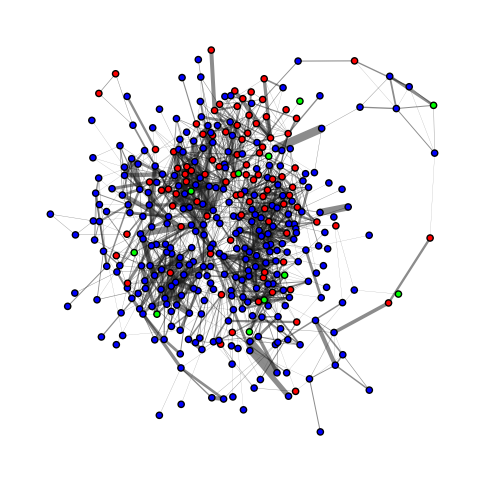

In [68]:
plt.figure(figsize=[6, 6])
nx.draw_networkx_nodes(
    G = G_cns_bt_f2f_p_lcc, 
    pos = nx.get_node_attributes(G=G_cns_bt_f2f_p_lcc, name='pos'), 
    node_size = 20, 
    node_color = list(nx.get_node_attributes(G=G_cns_bt_f2f_p_lcc, name='sex').values()), 
    cmap = plt.cm.brg, 
    linewidths = 1., 
    edgecolors = 'black'
)
nx.draw_networkx_edges(
    G = G_cns_bt_f2f_p_lcc, 
    pos = nx.get_node_attributes(G=G_cns_bt_f2f_p_lcc, name='pos'), 
    width = [width/200 for width in nx.get_edge_attributes(G=G_cns_bt_f2f_p_lcc, name='strength').values()], 
    alpha = .5, 
    edge_cmap = plt.cm.rainbow, 
    node_size = 20
)
plt.box(False)
plt.savefig('results/G_cns_bt_f2f_p_lcc.pdf')
plt.savefig('results/G_cns_bt_f2f_p_lcc.png')

The unlayered directed communication network where edge weights are averaged is:

In [69]:
D_cns_communication_week1_lcc = weighted_multigraph_to_graph(G=MD_cns_communication_week1_lcc, directed=True, fun='mean')

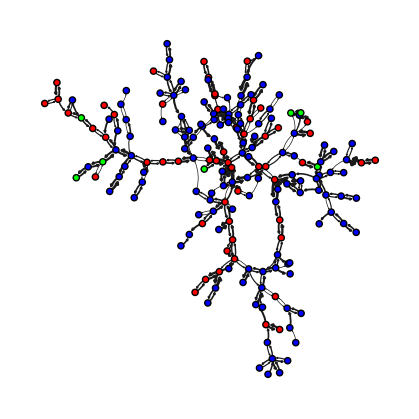

In [70]:
plt.figure(figsize=[4, 4])
nx.draw(
    G = D_cns_communication_week1_lcc, 
    pos = nx.get_node_attributes(G=D_cns_communication_week1_lcc, name='pos'), 
    node_size = 20, 
    node_color = list(nx.get_node_attributes(G=D_cns_communication_week1_lcc, name='sex').values()), 
    cmap = plt.cm.brg, 
    linewidths = 1., 
    edgecolors = 'black', 
    width = [width/2 for width in nx.get_edge_attributes(G=D_cns_communication_week1_lcc, name='weight').values()], 
    arrowsize = [arrowsize for arrowsize in nx.get_edge_attributes(G=D_cns_communication_week1_lcc, name='weight').values()], 
    connectionstyle = 'arc3, rad=0.2'
)
plt.savefig('results/D_cns_communication_week1_lcc.pdf')
plt.savefig('results/D_cns_communication_week1_lcc.png')

The `weighted_digraph_to_graph()` function introduced in the previous session can also be applied to MultiDiGraphs. This is what the `layered` parameter is for:

In [71]:
def weighted_digraph_to_graph(G, layered, fun, reciprocal, weight='weight'):
    '''
    Transforms a weighted directed graph into a weighted undirected network.
    
    Parameters:
        G : DiGraph or MultiDiGraph
            Directed network to be transformed.
        layered : Boolean
            Whether or not G is a MultiDiGraph.
        fun : String
            Function how edge weights from two edge directions are treated mathematically. Valid functions are 'mean', 'sum', and 'max'.
        reciprocal : Boolean
            If True only keep edges that appear in both directions in the original directed graph.
        weight : String, default 'weight'
            Name of edge attribute.
    
    Returns:
        A weighted Graph.
    '''
    G = G.copy()
    
    for u, v, data in G.edges(data=True):
        data['diweight'] = data.pop(weight)
    
    if layered:
        for node in G:
            for neighbor in nx.neighbors(G, node):
                for key in G[node][neighbor].keys():
                    if node in nx.neighbors(G, neighbor):
                        if key in G[neighbor][node].keys():
                            if fun == 'mean':
                                G.edges[node, neighbor, key][weight] = (G.edges[node, neighbor, key]['diweight'] + G.edges[neighbor, node, key]['diweight']) / 2
                            elif fun == 'sum':
                                G.edges[node, neighbor, key][weight] = (G.edges[node, neighbor, key]['diweight'] + G.edges[neighbor, node, key]['diweight'])
                            elif fun == 'max':
                                G.edges[node, neighbor, key][weight] = max(G.edges[node, neighbor, key]['diweight'], G.edges[neighbor, node, key]['diweight'])
                            else:
                                raise NotImplementedError("Valid functions are 'mean', 'sum', and 'max'.")
                    else:
                        G.edges[node, neighbor, key][weight] = G.edges[node, neighbor, key]['diweight']
    else:
        for node in G:
            for neighbor in nx.neighbors(G, node):
                if node in nx.neighbors(G, neighbor):
                    if fun == 'mean':
                        G.edges[node, neighbor][weight] = (G.edges[node, neighbor]['diweight'] + G.edges[neighbor, node]['diweight']) / 2
                    elif fun == 'sum':
                        G.edges[node, neighbor][weight] = (G.edges[node, neighbor]['diweight'] + G.edges[neighbor, node]['diweight'])
                    elif fun == 'max':
                        G.edges[node, neighbor][weight] = max(G.edges[node, neighbor]['diweight'], G.edges[neighbor, node]['diweight'])
                    else:
                        raise NotImplementedError("Valid functions are 'mean', 'sum', and 'max'.")
                else:
                    G.edges[node, neighbor][weight] = G.edges[node, neighbor]['diweight']
    
    for u, v, data in G.edges(data=True):
        del data['diweight']
    
    G = G.to_undirected(reciprocal=reciprocal)
    
    return G

The undirected multilayer communication network where edge weights are averaged is:

In [72]:
MG_cns_communication_week1_lcc = weighted_digraph_to_graph(G=MD_cns_communication_week1_lcc, layered=True, fun='mean', reciprocal=False)

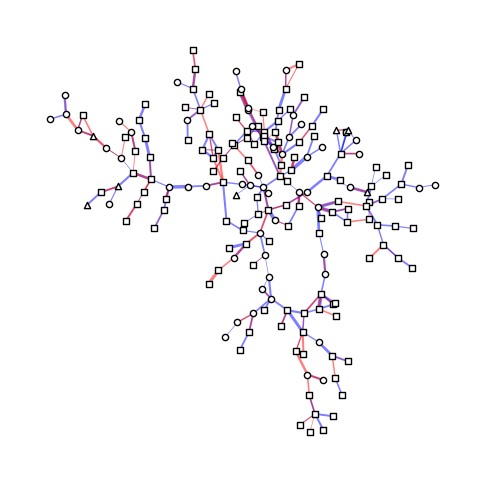

In [73]:
plt.figure(figsize=[6, 6])
for i in range(3):
    nx.draw_networkx_nodes(
        G = MG_cns_communication_week1_lcc, 
        pos = nx.get_node_attributes(G=MG_cns_communication_week1_lcc, name='pos'), 
        nodelist = [node for node, attribute in MG_cns_communication_week1_lcc.nodes(data=True) if attribute['sex'] == i], 
        node_size = 20, 
        node_color = 'white', 
        node_shape = shapes[i], 
        linewidths = 1., 
        edgecolors = 'black'
    )
nx.draw_networkx_edges(
    G = MG_cns_communication_week1_lcc, 
    pos = nx.get_node_attributes(G=MG_cns_communication_week1_lcc, name='pos'), 
    width = [width/2 for width in nx.get_edge_attributes(G=MG_cns_communication_week1_lcc, name='weight').values()], 
    edge_color = [key for u, v, key in MG_cns_communication_week1_lcc.edges.keys()], 
    alpha = .5, 
    edge_cmap = plt.cm.bwr, 
    node_size = 20
)
plt.box(False)
plt.savefig('results/MG_cns_communication_week1_lcc.pdf')
plt.savefig('results/MG_cns_communication_week1_lcc.png')

The unlayered undirected communication network where edge weights are averaged is:

In [74]:
G_cns_communication_week1_lcc = weighted_digraph_to_graph(G=D_cns_communication_week1_lcc, layered=False, fun='mean', reciprocal=False)

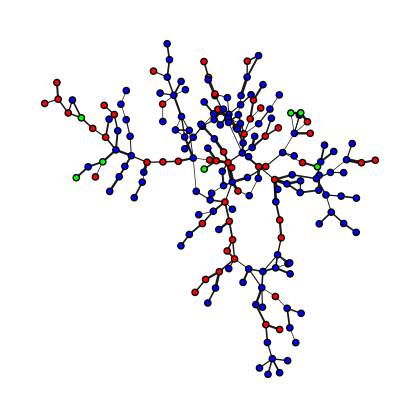

In [75]:
plt.figure(figsize=[4, 4])
nx.draw(
    G = G_cns_communication_week1_lcc, 
    pos = nx.get_node_attributes(G=G_cns_communication_week1_lcc, name='pos'), 
    node_size = 20, 
    node_color = list(nx.get_node_attributes(G=G_cns_communication_week1_lcc, name='sex').values()), 
    cmap = plt.cm.brg, 
    linewidths = 1., 
    edgecolors = 'black', 
    width = [width/2 for width in nx.get_edge_attributes(G=G_cns_communication_week1_lcc, name='weight').values()], 
    #edge_color = 'gray'
)
plt.savefig('results/G_cns_communication_week1_lcc.pdf')
plt.savefig('results/G_cns_communication_week1_lcc.png')

Maybe the biggest problem with NetworkX drawing is that it is quite complicated to not have edges from different layers (with different colors) overlay each other. Whatever edge comes last in the edgelist will be drawn on top of the edges from other layers. The [graph-tool](https://graph-tool.skewed.de/) package automatically employs curved edges to avoid edge overlay. Export your network in the GML format to transfer it to graph-tool (the previous session teaches how).

Finally, let us export some networks as a pickle to use them in later sessions:

In [76]:
import pickle

In [77]:
with open('results/MD_cns_communication_week1_lcc.pickle', 'wb') as f:
    pickle.dump(MD_cns_communication_week1_lcc.copy(), f, pickle.HIGHEST_PROTOCOL)
with open('results/D_cns_communication_week1_lcc.pickle', 'wb') as f:
    pickle.dump(D_cns_communication_week1_lcc.copy(), f, pickle.HIGHEST_PROTOCOL)
with open('results/MG_cns_communication_week1_lcc.pickle', 'wb') as f:
    pickle.dump(MG_cns_communication_week1_lcc.copy(), f, pickle.HIGHEST_PROTOCOL)
with open('results/G_cns_communication_week1_lcc.pickle', 'wb') as f:
    pickle.dump(G_cns_communication_week1_lcc.copy(), f, pickle.HIGHEST_PROTOCOL)
with open('results/MG_cns_bt_f2f_p_lcc.pickle', 'wb') as f:
    pickle.dump(MG_cns_bt_f2f_p_lcc.copy(), f, pickle.HIGHEST_PROTOCOL)
with open('results/G_cns_bt_f2f_p_lcc.pickle', 'wb') as f:
    pickle.dump(G_cns_bt_f2f_p_lcc.copy(), f, pickle.HIGHEST_PROTOCOL)

This concludes Session C2. Multilayer and multimodal network construction. The networks we have constructed, enriched, and layouted here will be the basis for the network analyses to follow in Sessions D1 and D2.

## References

### Recommended readings

Platt, E. L. (2019). *Network Science with Python and NetworkX Quick Start Guide*. Packt. https://www.packtpub.com/product/network-science-with-python-and-networkx-quick-start-guide/9781789955316. *Systematic introduction to the practice of network preprocessing and analysis. All Jupyter Notebooks are publically available on the [website](https://github.com/PacktPublishing/Network-Science-with-Python-and-NetworkX-Quick-Start-Guide). For this session, read **chs. 4 and 10** on bipartite and multilayer networks.*

### Complementary readings

Artime, O., Benigni, B., Bertagnolli, G., d'Andrea, V., Gallotti, R., Ghavasieh, A., Raimondo, S., & De Domenico, M. (2022). *Multilayer Network Science*. Cambridge University Press. https://doi.org/10.1017/9781009085809. *Interdisciplinary state-of-the-art account of the topic, quite advanced and mathematical.*

Breiger, R. L. (1974). "The duality of persons and groups". *Social Forces* 53:181–190. https://doi.org/10.1093/sf/53.2.181. *A fundamental paper about the sociological use of bipartite network structures.*

Butts, C. T., Lomi, A., Snijders, T. A. B., & Stadtfeld, C. (2023). "Relational event models in network science." *Network Science* 11:175–183. https://doi.org/10.1017/nws.2023.9.

Lee, M. & Martin, J. L. (2018). "Doorway to the dharma of duality". *Poetics* 68:18–30. https://doi.org/10.1016/j.poetic.2018.01.001. *A methodological account of socio-cultural analysis using publication data.*

Ma, E. & Seth, M. (2022). *Network Analysis Made Simple*. LeanPub. https://leanpub.com/nams. *An easy, well-maintained, and self-explanatory resource for NetworkX self-education that hides the inner workings of algorithms in custom functions. Use the [website](https://ericmjl.github.io/Network-Analysis-Made-Simple/) as a guide to Jupyter Notebooks on constructing, importing, exporting, and analyzing networks. You can also launch a binder session to execute notebooks in the cloud.*

Menczer, F., Fortunato, S., & Davis, C. A. (2020). *A First Course in Network Science*. Cambridge University Press. https://doi.org/10.1017/9781108653947. *An introductory course with exercises that emerged from years of teaching network analysis using NetworkX. Written from the physicist's perspective, this book is focused on the network science paradigms of small-world networks, scale-free networks, community detection, and complex systems modeling. The [website](https://cambridgeuniversitypress.github.io/FirstCourseNetworkScience/) provides all code in the form of Jupyter Notebooks, data, and solutions to the exercises.*

Mones, E., Stopczynski, A., & Lehmann, S. (2017). "Contact activity and dynamics of the social core". *EPJ Data Science* 6:6. https://doi.org/10.1140/epjds/s13688-017-0103-y.

Sapiezynski, P., Stopczynski, A., Lassen, D. D., & Lehmann, S. (2019). "Interaction data from the Copenhagen Networks Study". *Scientific Data* 6:315 (2019). https://doi.org/10.1038/s41597-019-0325-x. *Description of one of the richest publicly available multilayer network datasets.*

Sekara, V., Stopczynski, A., & Lehmann, S. (2016). "Fundamental structures of dynamic social networks". *Proceedings of the National Academy of Sciences* 113:9977–9982. https://doi.org/10.1073/pnas.1602803113. *Insightful multilayer analysis of the Copenhagen Networks Study interaction dataset.*

Soundarajan, S., Tamersoy, A., Khalil, E. B., Eliassi-Rad, T., Chau, D. H., Gallagher, B., & Roundy, K. (2016). "Generating graph snapshots from streaming edge data". In: *Proceedings of the 25th International Conference Companion on World Wide Web - WWW ’16 Companion* (pp. 109–110). ACM Press. https://doi.org/10.1145/2872518.2889398. *Flexible method for creating network snapshots.*

<div class='alert alert-block alert-success'>
<b>Document information</b>

Contact and main author: Haiko Lietz

Contributors: N. Gizem Bacaksizlar Turbic

Version date: 18 August 2023

License: Creative Commons Attribution 4.0 International (CC BY 4.0)
</div>